# Assignment 10: Regression with discrete variables
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered all previous assignments (especially 8, 9) before starting the assignment. Import the regression functions that you used for the last homeworks. 

In [2]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as so
import pandas as pd
import numpy as np

def simpleRegPredict(b,x):
    """Prediction function for simple regression
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
    Returns:
        yp (array): array of predicted y valuess
    """
    yp=b[0]+b[1]*x
    return yp

def simpleRegLossRSS(b,x,y):
    """Simple residual sums of squares loss functions
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
        y (array): array of y values

    Returns:
        rss (float): Residual sums of squares
        deriv (array): array of derivatives of the loss function with respect to b
    """
    predY = simpleRegPredict(b,x)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0]=-2*sum(res)
    deriv[1]=-2*sum(res*x)
    return (rss,deriv)

def plotPrediction(b,x,y,predfcn):
    """Plot the prediction of a simple regression
    Args:
        b (array): array of parameter values
        x (array): array of x values
        y (array): array of y values
        predfcn (function): prediction function
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    xp = np.linspace(min(x),max(x),num=50)
    yp = predfcn(b,xp)
    ax.plot(xp,yp,'r')

def simpleRegFit(x,y,lossFcn=simpleRegLossRSS):
    """Perform simple regression fit with a loss function
    Args:
        x (array): array of x values
        y (array): array of y values
        lossFcn (function): Loss function Defaults to simpleRegLossRSS.

    Returns:
        R2 (float): Coefficient of determination
        b (array): array of fitted parameter values
    """
    b0=[np.mean(y),0]
    RES = so.minimize(lossFcn,b0,args=(x,y),jac=True)
    b=RES.x # Results
    plotPrediction(b,x,y,simpleRegPredict)
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,grad = simpleRegLossRSS(b,x,y)
    R2 = 1-RSS/TSS
    return (R2,b)

def addPrediction(b,x,predFunc,ax,linestyle='r:'):
    """Add a prediction to a plot
    Args:
        b (array): array of parameter values
        x (array): array of x values
        predFunc (function): prediction function
        ax (axis): axis to plot on
        linestyle (string): linestyle for the plot
    """
    xrange = max(x)-min(x)
    xp = np.linspace(min(x)-xrange/30,max(x)+xrange/30,num=50)
    yp = predFunc(b,xp)
    ax.plot(xp,yp,linestyle)
    return(ax)

def multRegPredict(b,D,xname):
    """Model prediction function for multiple regression

    Args:
        b (array): Q+1 regression coefficients for Q variables
        D (pd.DataFrame): Data frame
        xname (list): Names of explanatory variables

    Returns:
        yp (array): predicted y-values
    """
    yp=np.ones(len(D.index))*b[0]        # Intercept
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value
    return yp

def multRegLossRSS(b,D,y,xname):
    """Residual sums of squares loss function for multiple regression
    Args:
        b (array): Q+1 regression coefficients for Q variables
        D (pd.DataFrame): Data frame
        xname (list): Names of explanatory variables

    Returns:
        rss (float): Residual sums of squares
        deriv (array): array of derivatives of the loss function with respect to b
    """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    """Multiple regression fitting function
    Args:
        D (pd.DataFrame): Data frame
        y (array): array of y values
        xname (list): Names of explanatory variables

    Returns:
        R2 (float): Coefficient of determination
        b (array): array of fitted parameter values
    """
    N=len(xname)
    b0=np.zeros((N+1,))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),
                    jac=True,
                    tol=1e-3)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS
    return (R2,b)

def bootstrapReg(D,y,args,fitfcn,numIter=1000):
    """Bootstrap for regression

    Args:
        D (pd.DataFrame): Data frame with explanatory variables
        y (array): array of y values
        args (tuple): additional arguments for the fit function
        fitfcn (function): fit function
        numIter (int, optional): Number of bootstrap samples. Defaults to 1000.

    Returns:
        stats(array): 2-D array of parameter values
    """
    r2,b=fitfcn(D,y,args)
    numParams=len(b)
    N = len(D.index)
    ind  = np.arange(N)
    stats = np.zeros((numIter,numParams))
    for i in range(numIter):
        sample=np.random.choice(ind,N)
        r2,stats[i,:]=fitfcn(D.iloc[sample],y[sample],args)
    return stats

def confidenceInt(data,perc):
    """Confidence interval for data from percentiles method
    Args:
        data (array): _description_
        perc (Percent within confidence interval): percent within confidence interval
    Returns:
        int (tuple): tuple with lower and upper bounds of confidence interval
    """
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int

## Task 1: Discrete predictor variables

### Question 1.1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'

Use your function `multRegFit` from last homework to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

Text(0.5, 1.0, 'Body Length vs Sex')

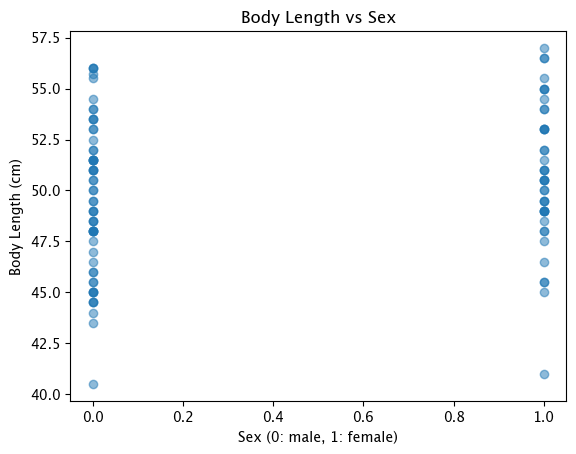

In [3]:
df = pd.read_csv('possum.csv')
df['bodyL'] = df['totalL'] - df['tailL'] 
df['popI'] = df['pop'] == 'Vic'
poplID = np.double(df['popI'])
df['popI'] = poplID

df['sexI'] = df['sex'] == 'f'
sexlID = np.double(df['sexI'])
df['sexI'] = sexlID


R2, b = multRegFit(df, df['bodyL'], ['sexI'])
plt.scatter(df['sexI'], df['bodyL'], alpha=0.5)
plt.xlabel('Sex (0: male, 1: female)')
plt.ylabel('Body Length (cm)')
plt.title('Body Length vs Sex')


### Question 1.2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the confidence interval. Does the confidence interval include 0? What does this mean for the relationship between sex and body length?

AttributeError: 'numpy.ndarray' object has no attribute 'index'

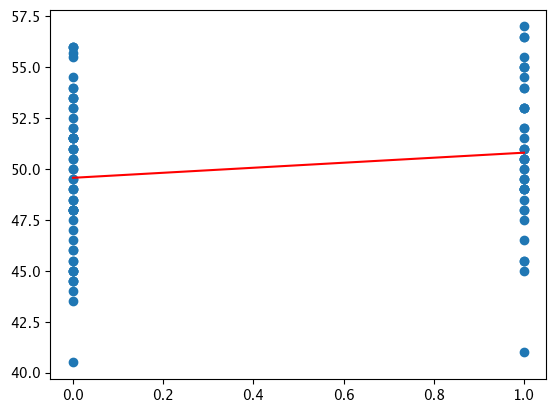

In [5]:
df = pd.read_csv('possum.csv')
df['bodyL'] = df['totalL'] - df['tailL']
df['sexI'] = (df['sex'] == 'f').astype(int)

# Extract sexI values as numpy array
x = df['sexI'].values
y = df['bodyL'].values

stats = bootstrapReg(x, y, simpleRegLossRSS, simpleRegFit)

intercept_CI = confidenceInt(stats[:,0], 95)
slope_CI = confidenceInt(stats[:,1], 95)

print("95% Confidence Intervals:")
print(f"Intercept: ({intercept_CI[0]:.2f}, {intercept_CI[1]:.2f})")
print(f"Effect of sex: ({slope_CI[0]:.2f}, {slope_CI[1]:.2f})")

if slope_CI[0] <= 0 <= slope_CI[1]:
    print("\nThe confidence interval for sex includes 0,")
    print("suggesting no significant relationship between sex and body length")
else:
    print("\nThe confidence interval for sex does not include 0,")
    if slope_CI[0] > 0:
        print("suggesting females have significantly longer bodies than males")
    else:
        print("suggesting males have significantly longer bodies than females")

A CI that includesof 0 means the relationship is insignificant

### Question 1.3 (10pt)
Make a scatter plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two scatter plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

### Question 1.4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. How big is the effect of age onto body length in the context of the model? Does the confidence interval for the parameter include 0?


How big is the estimate of the effect of sex on body length? What is the CI? Does it include zero?   


### Question 1.5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a scatter plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. 

Which of the two population (Vic or other) has a larger mean body size? What is the mean differences in body size?  

Compare the mean difference in body size with the value of the regression coefficient for popI. Why are they not the same? 

In comparison to the simple mean difference in body size, how do you interpret the value of the regression coefficient for popI?  

### Question 1.6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. In the conext of the model, is there evidence for a positive effect of age onto body length? How about the relationship between population and body length? 


## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 2.1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] + ... 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



### Question 2.2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


### Question 2.3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

### Question 2.4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

### Question 2.5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 